In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...


Loading and preparing data...
Original dataset dimensions: (4505, 2)
Missing values in input_text: 0
Missing values in target_text: 0
Clean dataset dimensions: (4505, 2)
Number of unique medications: 2814
Average examples per medication: 1.60

Sample data:
                                          input_text          target_text
0  anticoagulation in adult patients with acute c...            Lepirudin
1  treating locally or regionally advanced squamo...            Cetuximab
2                       metastatic colorectal cancer            Cetuximab
3      the treatment of ras-mutant colorectal cancer            Cetuximab
4         for treatment of cutaneous t-cell lymphoma  Denileukin diftitox

Medication distribution:
Medications with only one example: 1619
Medications with 2-4 examples: 1170
Medications with 5+ examples: 25
Medications with 10+ examples: 1

Performing data augmentation...
Found 2427 rare medications to augment
Original dataset size: (4505, 2)
Augmented dataset size: (1

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Training set: (11367, 2), Test set: (2843, 2)

Creating embeddings for all conditions...
Processing batch 10/356
Processing batch 20/356
Processing batch 30/356
Processing batch 40/356
Processing batch 50/356
Processing batch 60/356
Processing batch 70/356
Processing batch 80/356
Processing batch 90/356
Processing batch 100/356
Processing batch 110/356
Processing batch 120/356
Processing batch 130/356
Processing batch 140/356
Processing batch 150/356
Processing batch 160/356
Processing batch 170/356
Processing batch 180/356
Processing batch 190/356
Processing batch 200/356
Processing batch 210/356
Processing batch 220/356
Processing batch 230/356
Processing batch 240/356
Processing batch 250/356
Processing batch 260/356
Processing batch 270/356
Processing batch 280/356
Processing batch 290/356
Processing batch 300/356
Processing batch 310/356
Processing batch 320/356
Processing batch 330/356
Processing batch 340/356
Processing batch 350/356
Created embeddings for 11367 conditions

Tra

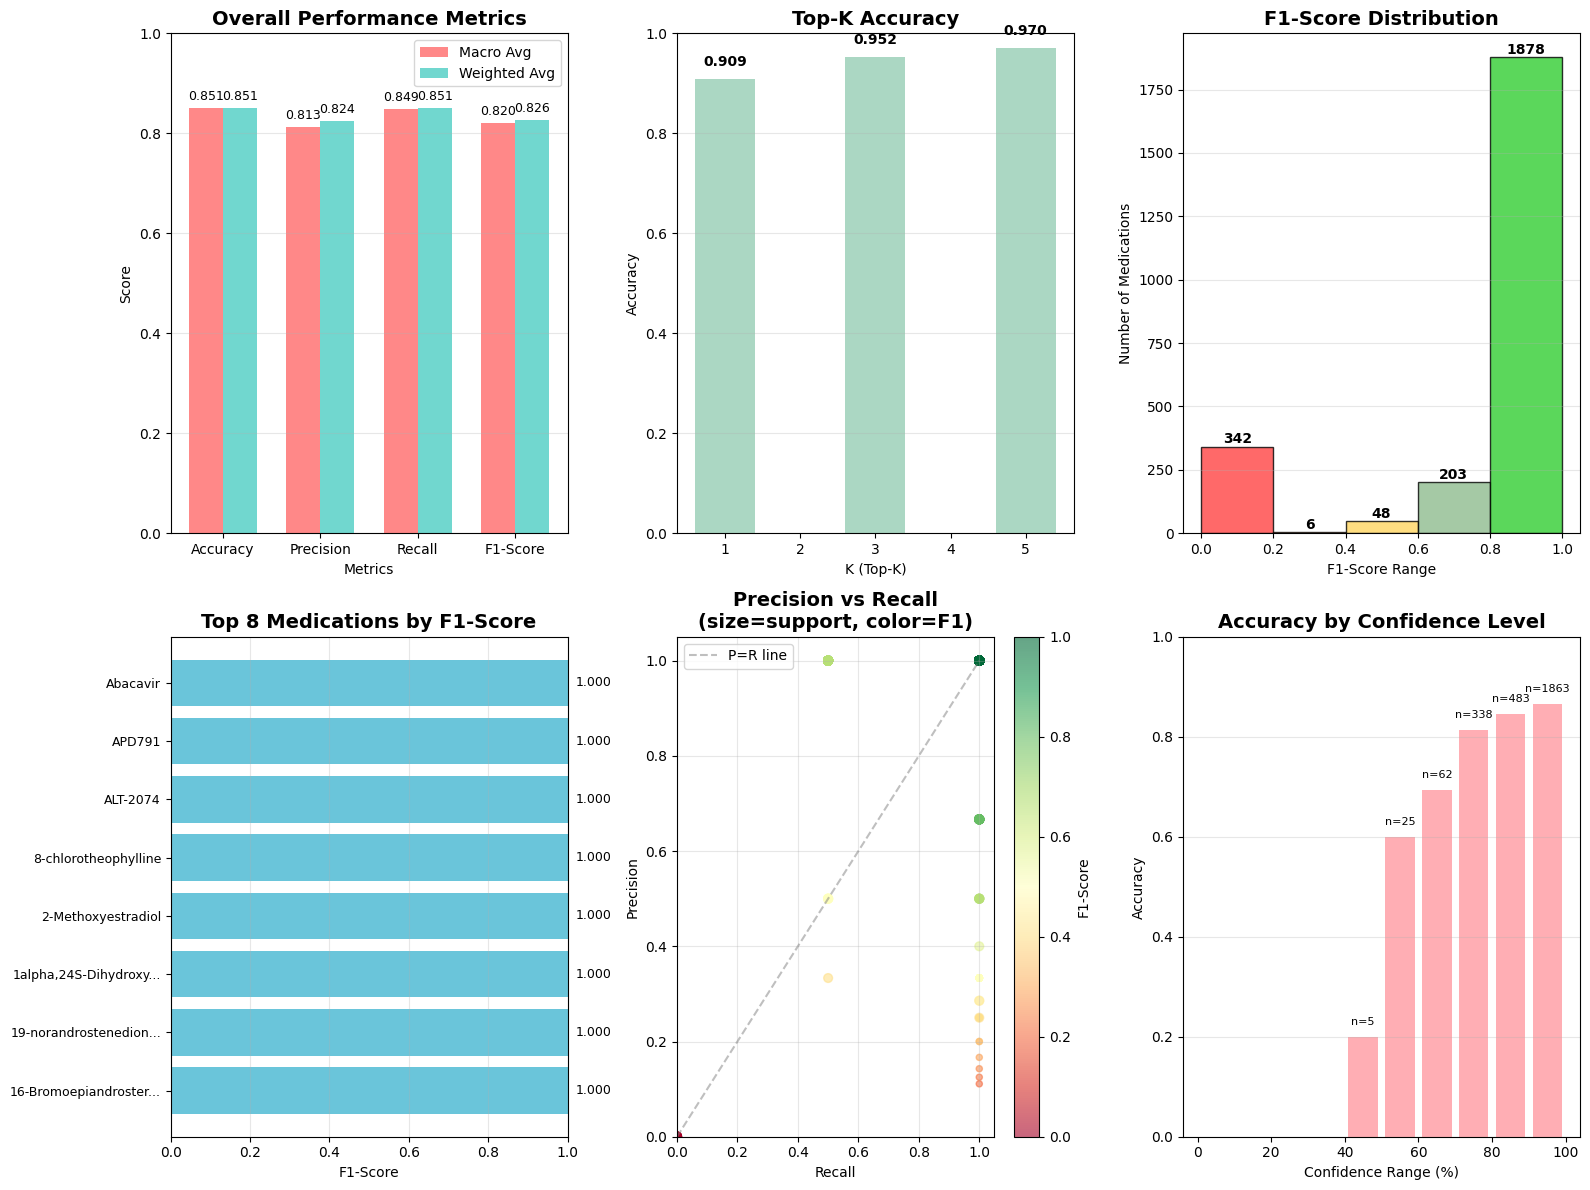


SUMMARY TABLE
Metric               Macro        Weighted    
------------------------------------------------------------
Accuracy             0.8509       0.8509      
Precision            0.8125       0.8241      
Recall               0.8486       0.8509      
F1-Score             0.8197       0.8258      

🎯 FINAL SUMMARY:
Overall Accuracy: 0.8509
Macro F1-Score: 0.8197
Weighted F1-Score: 0.8258
Top-3 Accuracy: 0.9518
Mean Confidence: 92.9%

Saving trained model...
Mounted at /content/drive
Running in Colab, saving to Google Drive path: /content/drive/MyDrive/medication_models/medication_recommendation_system.pkl
Model successfully saved to /content/drive/MyDrive/medication_models/medication_recommendation_system.pkl
Model saved to /content/drive/MyDrive/medication_models/medication_recommendation_system.pkl

=== Testing with sample conditions ===
Condition: 'muscle pain' → Medication: Ambenonium (Confidence: 71.86%)
Condition: 'joint aches' → Medication: Lornoxicam (Confidence: 79

In [ ]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import nltk
from nltk.corpus import wordnet
import random
import warnings
import pickle
import os
warnings.filterwarnings('ignore')

# Download required NLTK data for augmentation
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print("Loading and preparing data...")

# Step 1: Load and clean your data
# Update: Use your actual column names
df = pd.read_csv('drug_data.csv')

# Rename columns to match your data structure
# indication (medical condition) -> input_text
# name (medication) -> target_text
df = df.rename(columns={
    'indication': 'input_text',
    'name': 'target_text'
})

# Clean the data - handle missing values
print(f"Original dataset dimensions: {df.shape}")
print(f"Missing values in input_text: {df['input_text'].isna().sum()}")
print(f"Missing values in target_text: {df['target_text'].isna().sum()}")

# Remove rows with missing values
df = df.dropna(subset=['input_text', 'target_text'])

# Convert to string and clean
df['input_text'] = df['input_text'].astype(str).str.strip()
df['target_text'] = df['target_text'].astype(str).str.strip()

# Remove rows with empty strings
df = df[df['input_text'] != '']
df = df[df['target_text'] != '']

# Check if your data is correctly structured
print(f"Clean dataset dimensions: {df.shape}")
print(f"Number of unique medications: {df['target_text'].nunique()}")
print(f"Average examples per medication: {df.shape[0] / df['target_text'].nunique():.2f}")

# Sample of your data
print(f"\nSample data:")
print(df.head())

# Create medication counts for analysis
medication_counts = df['target_text'].value_counts()
print(f"\nMedication distribution:")
print(f"Medications with only one example: {(medication_counts == 1).sum()}")
print(f"Medications with 2-4 examples: {((medication_counts >= 2) & (medication_counts <= 4)).sum()}")
print(f"Medications with 5+ examples: {(medication_counts >= 5).sum()}")
print(f"Medications with 10+ examples: {(medication_counts >= 10).sum()}")

def augment_text(text, num_augmentations=2):
    """Create variations of text by replacing words with synonyms"""
    # Handle edge cases
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return [str(text)]  # Return original as string if problematic

    words = text.split()
    results = [text]  # Keep original

    for _ in range(num_augmentations):
        new_words = words.copy()
        # Try to replace 10-30% of words with synonyms
        num_to_replace = max(1, int(random.uniform(0.1, 0.3) * len(words)))

        for _ in range(num_to_replace):
            idx = random.randint(0, len(words) - 1)
            word = words[idx]

            # Find synonyms
            synonyms = []
            try:
                for syn in wordnet.synsets(word):
                    for lemma in syn.lemmas():
                        synonyms.append(lemma.name().replace('_', ' '))
            except:
                # Skip if there's any issue with wordnet
                continue

            if synonyms:
                new_words[idx] = random.choice(synonyms)

        results.append(' '.join(new_words))

    return results

print("\nPerforming data augmentation...")

# Augment rare medications data (those with fewer than 3 examples)
rare_meds = medication_counts[medication_counts < 3].index
augmented_data = []

print(f"Found {len(rare_meds)} rare medications to augment")

for idx, row in df.iterrows():
    condition = row['input_text']
    medication = row['target_text']

    # Skip if any value is problematic
    if pd.isna(condition) or pd.isna(medication):
        continue

    # Convert to string and clean
    condition = str(condition).strip()
    medication = str(medication).strip()

    if condition == '' or medication == '':
        continue

    # Always add the original example
    augmented_data.append((condition, medication))

    # Augment rare medications more aggressively
    if medication in rare_meds:
        try:
            augmented_conditions = augment_text(condition, num_augmentations=3)
            for aug_condition in augmented_conditions[1:]:  # Skip first which is original
                if aug_condition and aug_condition.strip():  # Make sure it's not empty
                    augmented_data.append((aug_condition, medication))
        except Exception as e:
            print(f"Error augmenting '{condition}': {e}")
            continue

# Create new augmented DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=['input_text', 'target_text'])
print(f"Original dataset size: {df.shape}")
print(f"Augmented dataset size: {augmented_df.shape}")
print(f"Added {augmented_df.shape[0] - df.shape[0]} augmented examples")

# Step 3: Create a hybrid recommendation system
print("\nLoading biomedical embedding model (this may take a minute)...")
# Load a smaller biomedical sentence transformer model
embedder = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

# Split data for evaluation while keeping all medications in train set
def stratified_medication_split(df, test_size=0.2):
    """Split ensuring each medication appears in training set"""
    # Get medications with multiple examples for testing
    multi_example_meds = medication_counts[medication_counts >= 2].index
    test_eligible_df = df[df['target_text'].isin(multi_example_meds)]

    # Keep one example of each medication in training
    train_df = pd.DataFrame()
    for med in df['target_text'].unique():
        train_df = pd.concat([train_df, df[df['target_text'] == med].iloc[:1]])

    # Get remaining data that can go to test
    remaining_df = df.drop(train_df.index)

    # Split remaining data
    if len(remaining_df) > 0:
        _, test_df = train_test_split(
            remaining_df,
            test_size=test_size/(1-len(train_df)/len(df)),
            stratify=remaining_df['target_text'] if len(remaining_df) > len(multi_example_meds) else None,
            random_state=42
        )
        # Add back the reserved training examples
        train_df = pd.concat([train_df, remaining_df.drop(test_df.index)])
    else:
        test_df = pd.DataFrame(columns=df.columns)

    return train_df, test_df

# Create train/test split
train_df, test_df = stratified_medication_split(augmented_df, test_size=0.2)
print(f"\nTraining set: {train_df.shape}, Test set: {test_df.shape}")

print("\nCreating embeddings for all conditions...")
# Create reference database of condition embeddings
all_conditions = train_df['input_text'].tolist()
all_medications = train_df['target_text'].tolist()

# Create embeddings in batches to avoid memory issues
batch_size = 32
all_embeddings = []

for i in range(0, len(all_conditions), batch_size):
    if (i // batch_size + 1) % 10 == 0:
        print(f"Processing batch {i // batch_size + 1}/{(len(all_conditions) + batch_size - 1) // batch_size}")

    batch = all_conditions[i:i+batch_size]
    batch_embeddings = embedder.encode(batch, convert_to_tensor=True)
    all_embeddings.append(batch_embeddings)

# Concatenate all batches
all_embeddings = torch.cat(all_embeddings, dim=0)
print(f"Created embeddings for {len(all_conditions)} conditions")

# Step 4: Implement recommend_medication function
def recommend_medication(query, embedder, all_embeddings, all_conditions, all_medications, top_k=5):
    """Recommend medications based on condition similarity"""
    # Encode the query
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # Calculate cosine similarity with all known conditions
    cos_scores = util.cos_sim(query_embedding, all_embeddings)[0]

    # Get top matches
    top_k = min(top_k, len(all_conditions))
    top_results = torch.topk(cos_scores, k=top_k)

    # Return the corresponding medications with confidence scores
    results = []
    for score, idx in zip(top_results[0], top_results[1]):
        results.append({
            'medication': all_medications[idx],
            'condition': all_conditions[idx],
            'confidence': score.item()
        })

    return results

# Step 5: Add a simple backup classifier for difficult cases
print("\nTraining backup classifier...")

# Use TF-IDF + LogisticRegression as backup
vectorizer = TfidfVectorizer(max_features=2000)
X_train_vec = vectorizer.fit_transform(train_df['input_text'])

# Use classifiers that can handle many classes
clf = LogisticRegression(max_iter=1000, C=10.0, class_weight='balanced')
clf.fit(X_train_vec, train_df['target_text'])

# Step 6: Create the final prediction system
def predict_medication(query, embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf,
                     voting_k=10, show_details=False):
    """Predict medication with improved confidence calculation and exact match detection"""
    # First check for exact matches in the training data
    if query in all_conditions:
        # Find the index of the exact match
        exact_match_indices = [i for i, condition in enumerate(all_conditions) if condition == query]

        if exact_match_indices:
            # Get the medication for the exact match
            exact_match_med = all_medications[exact_match_indices[0]]

            if show_details:
                print(f"\nEXACT MATCH FOUND: '{query}' → {exact_match_med}")

            return {
                'medication': exact_match_med,
                'confidence': 99.9  # Very high confidence for exact matches
            }

    # Get recommendations using similarity
    recommendations = recommend_medication(query, embedder, all_embeddings, all_conditions,
                                          all_medications, top_k=voting_k)

    # Check if there's an extremely high similarity (like 0.98+)
    highest_sim = recommendations[0]['confidence'] if recommendations else 0
    if highest_sim > 0.98:
        top_match = recommendations[0]
        if show_details:
            print(f"\nVERY CLOSE MATCH: '{top_match['condition']}' → {top_match['medication']} (Similarity: {highest_sim:.4f})")

        return {
            'medication': top_match['medication'],
            'confidence': round(highest_sim * 100, 2)
        }

    if show_details and recommendations:
        print("\nTop similar conditions:")
        for i, rec in enumerate(recommendations[:3], 1):
            print(f"{i}. {rec['condition']} → {rec['medication']} (Similarity: {rec['confidence']:.4f})")

    # For non-exact matches, proceed with voting
    votes = {}
    for rec in recommendations:
        med = rec['medication']
        confidence = rec['confidence']
        if med not in votes:
            votes[med] = 0
        votes[med] += confidence

    # Get top medication from voting
    if votes:
        top_medication = max(votes.items(), key=lambda x: x[1])
        top_med, top_score = top_medication

        # Better confidence calculation for strong similarities
        best_matches = [rec['confidence'] for rec in recommendations if rec['medication'] == top_med]
        if best_matches:
            # Use the maximum similarity as base confidence, boosted by consensus
            max_sim = max(best_matches)
            # Boost confidence if multiple recommendations agree
            consensus_boost = min(0.25, (len(best_matches) - 1) * 0.05)
            adjusted_confidence = min(0.99, max_sim + consensus_boost)

            # Use classifier as verification
            X_query_vec = vectorizer.transform([query])
            clf_probs = clf.predict_proba(X_query_vec)[0]
            top_idx = clf_probs.argmax()
            clf_prediction = clf.classes_[top_idx]
            clf_confidence = clf_probs[top_idx]

            # If classifier agrees with similarity-based approach, boost confidence further
            if clf_prediction == top_med:
                combined_confidence = min(0.99, adjusted_confidence * 0.7 + clf_confidence * 0.3)
                return {
                    'medication': top_med,
                    'confidence': round(combined_confidence * 100, 2)
                }
            else:
                return {
                    'medication': top_med,
                    'confidence': round(adjusted_confidence * 100, 2)
                }

    # Fallback to classifier if no strong similarity-based prediction
    X_query_vec = vectorizer.transform([query])
    clf_probs = clf.predict_proba(X_query_vec)[0]
    top_idx = clf_probs.argmax()
    clf_prediction = clf.classes_[top_idx]
    clf_confidence = clf_probs[top_idx]

    adjusted_clf_confidence = min(0.9, clf_confidence * 1.2)

    return {
        'medication': clf_prediction,
        'confidence': round(adjusted_clf_confidence * 100, 2)
    }

# COMPREHENSIVE EVALUATION FUNCTIONS
def comprehensive_evaluation(test_df, embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf):
    """
    Comprehensive evaluation with precision, recall, F1, accuracy and visualizations
    """
    print("\n" + "="*70)
    print("COMPREHENSIVE MEDICATION RECOMMENDATION EVALUATION")
    print("="*70)

    y_true = test_df['target_text'].tolist()
    X_test = test_df['input_text'].tolist()

    print(f"Evaluating on {len(X_test)} test samples...")
    print("Generating predictions with confidence scores...")

    # Get predictions and confidence scores
    y_pred = []
    confidences = []
    top_k_recommendations = []

    for i, query in enumerate(X_test):
        if (i + 1) % 50 == 0:
            print(f"Processing {i + 1}/{len(X_test)} predictions...")

        # Get prediction with confidence
        result = predict_medication(query, embedder, all_embeddings, all_conditions,
                                  all_medications, vectorizer, clf)
        y_pred.append(result['medication'])
        confidences.append(result['confidence'])

        # Get top-5 recommendations for ranking metrics
        top_recs = recommend_medication(query, embedder, all_embeddings, all_conditions,
                                      all_medications, top_k=5)
        top_k_recommendations.append([rec['medication'] for rec in top_recs])

    confidences = np.array(confidences)

    # Calculate all metrics
    print("\nCalculating metrics...")

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 - macro and weighted averages
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Per-class metrics
    unique_labels = sorted(list(set(y_true)))
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0, labels=unique_labels
    )

    # Top-K accuracy
    top_k_accuracies = {}
    for k in [1, 3, 5]:
        correct = sum(1 for true_med, top_k_preds in zip(y_true, top_k_recommendations)
                     if true_med in top_k_preds[:k])
        top_k_accuracies[k] = correct / len(y_true)

    # Mean Reciprocal Rank
    reciprocal_ranks = []
    for true_med, top_k_preds in zip(y_true, top_k_recommendations):
        rank = float('inf')
        for i, pred_med in enumerate(top_k_preds):
            if pred_med == true_med:
                rank = i + 1
                break
        reciprocal_ranks.append(1.0 / rank if rank != float('inf') else 0.0)
    mrr = np.mean(reciprocal_ranks)

    # Print results
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)

    print("\n1. OVERALL METRICS:")
    print(f"   Accuracy:           {accuracy:.4f}")
    print(f"   Macro Precision:    {precision_macro:.4f}")
    print(f"   Macro Recall:       {recall_macro:.4f}")
    print(f"   Macro F1-Score:     {f1_macro:.4f}")
    print(f"   Weighted Precision: {precision_weighted:.4f}")
    print(f"   Weighted Recall:    {recall_weighted:.4f}")
    print(f"   Weighted F1-Score:  {f1_weighted:.4f}")

    print("\n2. RANKING METRICS:")
    for k in [1, 3, 5]:
        print(f"   Top-{k} Accuracy:     {top_k_accuracies[k]:.4f}")
    print(f"   Mean Reciprocal Rank: {mrr:.4f}")

    print("\n3. CONFIDENCE ANALYSIS:")
    print(f"   Mean Confidence:      {np.mean(confidences):.2f}%")
    print(f"   Std Confidence:       {np.std(confidences):.2f}%")
    print(f"   Min Confidence:       {np.min(confidences):.2f}%")
    print(f"   Max Confidence:       {np.max(confidences):.2f}%")

    # Per-medication analysis
    per_med_df = pd.DataFrame({
        'medication': unique_labels,
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1_score': f1_per_class,
        'support': support_per_class
    })

    print("\n4. TOP PERFORMING MEDICATIONS (by F1-score, min 2 samples):")
    top_performers = per_med_df[per_med_df['support'] >= 2].nlargest(5, 'f1_score')
    for idx, row in top_performers.iterrows():
        med_name = row['medication'][:50] + '...' if len(row['medication']) > 50 else row['medication']
        print(f"   {med_name}")
        print(f"   P: {row['precision']:.3f} | R: {row['recall']:.3f} | F1: {row['f1_score']:.3f} | Support: {int(row['support'])}")

    print("\n5. DATASET STATISTICS:")
    medication_counts_test = pd.Series(y_true).value_counts()
    print(f"   Total test samples:        {len(y_true)}")
    print(f"   Unique medications:        {len(set(y_true))}")
    print(f"   Medications with 1 sample: {(medication_counts_test == 1).sum()}")
    print(f"   Medications with 2+ samples: {(medication_counts_test >= 2).sum()}")
    print(f"   Medications with 5+ samples: {(medication_counts_test >= 5).sum()}")

    # Error analysis
    correct_mask = np.array([pred == true for pred, true in zip(y_pred, y_true)])
    high_conf_errors = (confidences > 80) & (~correct_mask)
    low_conf_correct = (confidences < 60) & correct_mask

    print(f"\n6. ERROR ANALYSIS:")
    print(f"   High-confidence errors (>80% conf, wrong): {high_conf_errors.sum()}")
    print(f"   Low-confidence correct (<60% conf, right):  {low_conf_correct.sum()}")

    if high_conf_errors.sum() > 0:
        print(f"\n   Sample High-Confidence Errors:")
        error_indices = np.where(high_conf_errors)[0][:3]
        for idx in error_indices:
            condition = X_test[idx][:60] + '...' if len(X_test[idx]) > 60 else X_test[idx]
            print(f"   • Condition: {condition}")
            print(f"     True: {y_true[idx]}")
            print(f"     Predicted: {y_pred[idx]} (Confidence: {confidences[idx]:.1f}%)")

    print("\n" + "="*50)

    # Create visualizations
    create_evaluation_plots(accuracy, precision_macro, recall_macro, f1_macro,
                           precision_weighted, recall_weighted, f1_weighted,
                           top_k_accuracies, per_med_df, confidences,
                           correct_mask, y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'top_k_accuracies': top_k_accuracies,
        'mrr': mrr,
        'mean_confidence': np.mean(confidences),
        'per_med_df': per_med_df
    }

def create_evaluation_plots(accuracy, precision_macro, recall_macro, f1_macro,
                          precision_weighted, recall_weighted, f1_weighted,
                          top_k_accuracies, per_med_df, confidences,
                          correct_mask, y_true, y_pred):
    """Create comprehensive evaluation plots"""
    print("\nGenerating evaluation visualizations...")

    plt.style.use('default')
    sns.set_palette("husl")

    fig = plt.figure(figsize=(16, 12))

    # 1. Overall Metrics Comparison
    ax1 = plt.subplot(2, 3, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    macro_values = [accuracy, precision_macro, recall_macro, f1_macro]
    weighted_values = [accuracy, precision_weighted, recall_weighted, f1_weighted]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax1.bar(x - width/2, macro_values, width, label='Macro Avg',
                    color='#FF6B6B', alpha=0.8)
    bars2 = ax1.bar(x + width/2, weighted_values, width, label='Weighted Avg',
                    color='#4ECDC4', alpha=0.8)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. Top-K Accuracy
    ax2 = plt.subplot(2, 3, 2)
    k_values = list(top_k_accuracies.keys())
    k_accuracies = list(top_k_accuracies.values())

    bars = ax2.bar(k_values, k_accuracies, color='#96CEB4', alpha=0.8)
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Top-K Accuracy', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    for bar, acc in zip(bars, k_accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. F1-Score Distribution
    ax3 = plt.subplot(2, 3, 3)
    f1_scores = per_med_df['f1_score']

    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    colors = ['#FF4444', '#FF8C42', '#FFD662', '#8FBC8F', '#32CD32']

    counts, bin_edges, patches = ax3.hist(f1_scores, bins=bins, alpha=0.8, edgecolor='black')

    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)

    ax3.set_xlabel('F1-Score Range')
    ax3.set_ylabel('Number of Medications')
    ax3.set_title('F1-Score Distribution', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    for i, count in enumerate(counts):
        if count > 0:
            ax3.text((bins[i] + bins[i+1])/2, count + 0.5, str(int(count)),
                    ha='center', va='bottom', fontweight='bold')

    # 4. Top Performers
    ax4 = plt.subplot(2, 3, 4)
    top_performers = per_med_df.nlargest(8, 'f1_score')
    med_names = [med[:20] + '...' if len(med) > 20 else med for med in top_performers['medication']]

    bars = ax4.barh(range(len(med_names)), top_performers['f1_score'],
                    color='#45B7D1', alpha=0.8)
    ax4.set_yticks(range(len(med_names)))
    ax4.set_yticklabels(med_names, fontsize=9)
    ax4.set_xlabel('F1-Score')
    ax4.set_title('Top 8 Medications by F1-Score', fontsize=14, fontweight='bold')
    ax4.set_xlim(0, 1)
    ax4.grid(axis='x', alpha=0.3)

    for i, (bar, value) in enumerate(zip(bars, top_performers['f1_score'])):
        ax4.text(value + 0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontsize=9)

    # 5. Precision vs Recall Scatter
    ax5 = plt.subplot(2, 3, 5)
    sizes = per_med_df['support'] * 20
    scatter = ax5.scatter(per_med_df['recall'], per_med_df['precision'],
                         s=sizes, alpha=0.6, c=per_med_df['f1_score'],
                         cmap='RdYlGn', vmin=0, vmax=1)

    ax5.set_xlabel('Recall')
    ax5.set_ylabel('Precision')
    ax5.set_title('Precision vs Recall\n(size=support, color=F1)', fontsize=14, fontweight='bold')
    ax5.set_xlim(0, 1.05)
    ax5.set_ylim(0, 1.05)
    ax5.grid(True, alpha=0.3)
    ax5.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='P=R line')
    ax5.legend()

    cbar = plt.colorbar(scatter, ax=ax5)
    cbar.set_label('F1-Score')

    # 6. Confidence Analysis
    ax6 = plt.subplot(2, 3, 6)
    conf_bins = np.arange(0, 101, 10)
    bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
    bin_accuracies = []
    bin_counts = []

    for i in range(len(conf_bins) - 1):
        mask = (confidences >= conf_bins[i]) & (confidences < conf_bins[i+1])
        if mask.sum() > 0:
            bin_acc = correct_mask[mask].mean()
            bin_accuracies.append(bin_acc)
            bin_counts.append(mask.sum())
        else:
            bin_accuracies.append(0)
            bin_counts.append(0)

    bars = ax6.bar(bin_centers, bin_accuracies, width=8, alpha=0.7, color='#FF8C94')
    ax6.set_xlabel('Confidence Range (%)')
    ax6.set_ylabel('Accuracy')
    ax6.set_title('Accuracy by Confidence Level', fontsize=14, fontweight='bold')
    ax6.set_ylim(0, 1)
    ax6.grid(axis='y', alpha=0.3)

    for i, (bar, count, acc) in enumerate(zip(bars, bin_counts, bin_accuracies)):
        if count > 0:
            ax6.text(bar.get_x() + bar.get_width()/2, acc + 0.02,
                    f'n={count}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n" + "="*60)
    print("SUMMARY TABLE")
    print("="*60)
    print(f"{'Metric':<20} {'Macro':<12} {'Weighted':<12}")
    print("-" * 60)
    print(f"{'Accuracy':<20} {accuracy:<12.4f} {accuracy:<12.4f}")
    print(f"{'Precision':<20} {precision_macro:<12.4f} {precision_weighted:<12.4f}")
    print(f"{'Recall':<20} {recall_macro:<12.4f} {recall_weighted:<12.4f}")
    print(f"{'F1-Score':<20} {f1_macro:<12.4f} {f1_weighted:<12.4f}")
    print("="*60)

# RUN COMPREHENSIVE EVALUATION
print("="*70)
print("RUNNING COMPREHENSIVE EVALUATION")
print("="*70)

evaluation_results = comprehensive_evaluation(test_df, embedder, all_embeddings,
                                            all_conditions, all_medications, vectorizer, clf)

print(f"\n🎯 FINAL SUMMARY:")
print(f"Overall Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Macro F1-Score: {evaluation_results['f1_macro']:.4f}")
print(f"Weighted F1-Score: {evaluation_results['f1_weighted']:.4f}")
print(f"Top-3 Accuracy: {evaluation_results['top_k_accuracies'][3]:.4f}")
print(f"Mean Confidence: {evaluation_results['mean_confidence']:.1f}%")
print("="*70)

# Function to save the model components properly
def save_medication_model(embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf, model_path):
    """Save all components of the medication recommendation model to a pickle file"""
    try:
        os.makedirs(os.path.dirname(model_path), exist_ok=True)

        model_components = {
            'embedder': embedder,
            'all_embeddings': all_embeddings,
            'all_conditions': all_conditions,
            'all_medications': all_medications,
            'vectorizer': vectorizer,
            'clf': clf
        }

        with open(model_path, 'wb') as f:
            pickle.dump(model_components, f)

        print(f"Model successfully saved to {model_path}")

    except Exception as e:
        print(f"Error saving model: {str(e)}")

# Interactive prediction function
def interactive_prediction(embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf):
    """Interactive prediction loop for medication recommendations"""
    print("\n=== Medication Recommendation System ===")
    print("Enter medical conditions to get medication recommendations.")
    print("Type 'exit' to quit.")

    while True:
        query = input("\nEnter medical condition (e.g., 'muscle pain', 'joint aches'): ")
        if query.lower() in ['exit', 'quit', 'q']:
            break

        if not query.strip():
            continue

        result = predict_medication(query, embedder, all_embeddings, all_conditions,
                                  all_medications, vectorizer, clf, show_details=True)

        print(f"\nRecommended Medication: {result['medication']}")
        print(f"Confidence: {result['confidence']}%")

# Save the trained models for future use
print("\nSaving trained model...")
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    model_path = '/content/drive/MyDrive/medication_models/medication_recommendation_system.pkl'
    os.makedirs('/content/drive/MyDrive/medication_models', exist_ok=True)
    print(f"Running in Colab, saving to Google Drive path: {model_path}")
except:
    model_path = './medication_recommendation_system.pkl'
    print(f"Not running in Colab, saving to local path: {model_path}")

save_medication_model(embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf, model_path)
print(f"Model saved to {model_path}")

# Test the system with some examples
print("\n=== Testing with sample conditions ===")
test_conditions = [
    "muscle pain",
    "joint aches",
    "minor aches and pains",
    "inflammation"
]

for condition in test_conditions:
    result = predict_medication(condition, embedder, all_embeddings, all_conditions,
                              all_medications, vectorizer, clf, show_details=False)
    print(f"Condition: '{condition}' → Medication: {result['medication']} (Confidence: {result['confidence']}%)")

# Start interactive mode
print("\n" + "="*50)
interactive_prediction(embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf)

In [ ]:
# Add these imports to the top of your script (with your existing imports)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, classification_report

def comprehensive_evaluation(test_df, embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf):
    """
    Comprehensive evaluation with precision, recall, F1, accuracy and visualizations
    """
    print("\n" + "="*70)
    print("COMPREHENSIVE MEDICATION RECOMMENDATION EVALUATION")
    print("="*70)

    y_true = test_df['target_text'].tolist()
    X_test = test_df['input_text'].tolist()

    print(f"Evaluating on {len(X_test)} test samples...")
    print("Generating predictions with confidence scores...")

    # Get predictions and confidence scores
    y_pred = []
    confidences = []
    top_k_recommendations = []

    for i, query in enumerate(X_test):
        if (i + 1) % 10 == 0:
            print(f"Processing {i + 1}/{len(X_test)} predictions...")

        # Get prediction with confidence
        result = predict_medication(query, embedder, all_embeddings, all_conditions,
                                  all_medications, vectorizer, clf)
        y_pred.append(result['medication'])
        confidences.append(result['confidence'])

        # Get top-5 recommendations for ranking metrics
        top_recs = recommend_medication(query, embedder, all_embeddings, all_conditions,
                                      all_medications, top_k=5)
        top_k_recommendations.append([rec['medication'] for rec in top_recs])

    confidences = np.array(confidences)

    # Calculate all metrics
    print("\nCalculating metrics...")

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 - macro and weighted averages
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0, labels=sorted(list(set(y_true)))
    )

    # Top-K accuracy
    top_k_accuracies = {}
    for k in [1, 3, 5]:
        correct = sum(1 for true_med, top_k_preds in zip(y_true, top_k_recommendations)
                     if true_med in top_k_preds[:k])
        top_k_accuracies[k] = correct / len(y_true)

    # Mean Reciprocal Rank
    reciprocal_ranks = []
    for true_med, top_k_preds in zip(y_true, top_k_recommendations):
        rank = float('inf')
        for i, pred_med in enumerate(top_k_preds):
            if pred_med == true_med:
                rank = i + 1
                break
        reciprocal_ranks.append(1.0 / rank if rank != float('inf') else 0.0)
    mrr = np.mean(reciprocal_ranks)

    # Print results
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)

    print("\n1. OVERALL METRICS:")
    print(f"   Accuracy:           {accuracy:.4f}")
    print(f"   Macro Precision:    {precision_macro:.4f}")
    print(f"   Macro Recall:       {recall_macro:.4f}")
    print(f"   Macro F1-Score:     {f1_macro:.4f}")
    print(f"   Weighted Precision: {precision_weighted:.4f}")
    print(f"   Weighted Recall:    {recall_weighted:.4f}")
    print(f"   Weighted F1-Score:  {f1_weighted:.4f}")

    print("\n2. RANKING METRICS:")
    for k in [1, 3, 5]:
        print(f"   Top-{k} Accuracy:     {top_k_accuracies[k]:.4f}")
    print(f"   Mean Reciprocal Rank: {mrr:.4f}")

    print("\n3. CONFIDENCE ANALYSIS:")
    print(f"   Mean Confidence:      {np.mean(confidences):.2f}%")
    print(f"   Std Confidence:       {np.std(confidences):.2f}%")
    print(f"   Min Confidence:       {np.min(confidences):.2f}%")
    print(f"   Max Confidence:       {np.max(confidences):.2f}%")

    # Per-medication analysis
    unique_labels = sorted(list(set(y_true)))
    per_med_df = pd.DataFrame({
        'medication': unique_labels,
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1_score': f1_per_class,
        'support': support_per_class
    })

    print("\n4. TOP PERFORMING MEDICATIONS (by F1-score, min 2 samples):")
    top_performers = per_med_df[per_med_df['support'] >= 2].nlargest(5, 'f1_score')
    for idx, row in top_performers.iterrows():
        med_name = row['medication'][:50] + '...' if len(row['medication']) > 50 else row['medication']
        print(f"   {med_name}")
        print(f"   P: {row['precision']:.3f} | R: {row['recall']:.3f} | F1: {row['f1_score']:.3f} | Support: {int(row['support'])}")

    print("\n5. DATASET STATISTICS:")
    medication_counts = pd.Series(y_true).value_counts()
    print(f"   Total test samples:        {len(y_true)}")
    print(f"   Unique medications:        {len(set(y_true))}")
    print(f"   Medications with 1 sample: {(medication_counts == 1).sum()}")
    print(f"   Medications with 2+ samples: {(medication_counts >= 2).sum()}")
    print(f"   Medications with 5+ samples: {(medication_counts >= 5).sum()}")

    # Error analysis
    correct_mask = np.array([pred == true for pred, true in zip(y_pred, y_true)])
    high_conf_errors = (confidences > 80) & (~correct_mask)
    low_conf_correct = (confidences < 60) & correct_mask

    print(f"\n6. ERROR ANALYSIS:")
    print(f"   High-confidence errors (>80% conf, wrong): {high_conf_errors.sum()}")
    print(f"   Low-confidence correct (<60% conf, right):  {low_conf_correct.sum()}")

    if high_conf_errors.sum() > 0:
        print(f"\n   Sample High-Confidence Errors:")
        error_indices = np.where(high_conf_errors)[0][:2]
        for idx in error_indices:
            query = X_test[idx][:60] + '...' if len(X_test[idx]) > 60 else X_test[idx]
            print(f"   • Query: {query}")
            print(f"     True: {y_true[idx]}")
            print(f"     Predicted: {y_pred[idx]} (Confidence: {confidences[idx]:.1f}%)")

    print("\n" + "="*50)

    # Create visualizations
    create_evaluation_plots(accuracy, precision_macro, recall_macro, f1_macro,
                           precision_weighted, recall_weighted, f1_weighted,
                           top_k_accuracies, per_med_df, confidences,
                           correct_mask, y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'top_k_accuracies': top_k_accuracies,
        'mrr': mrr,
        'mean_confidence': np.mean(confidences),
        'per_med_df': per_med_df
    }

def create_evaluation_plots(accuracy, precision_macro, recall_macro, f1_macro,
                          precision_weighted, recall_weighted, f1_weighted,
                          top_k_accuracies, per_med_df, confidences,
                          correct_mask, y_true, y_pred):
    """
    Create comprehensive evaluation plots
    """
    print("\nGenerating evaluation visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Overall Metrics Comparison
    ax1 = plt.subplot(2, 3, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    macro_values = [accuracy, precision_macro, recall_macro, f1_macro]
    weighted_values = [accuracy, precision_weighted, recall_weighted, f1_weighted]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax1.bar(x - width/2, macro_values, width, label='Macro Avg',
                    color='#FF6B6B', alpha=0.8)
    bars2 = ax1.bar(x + width/2, weighted_values, width, label='Weighted Avg',
                    color='#4ECDC4', alpha=0.8)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. Top-K Accuracy
    ax2 = plt.subplot(2, 3, 2)
    k_values = list(top_k_accuracies.keys())
    k_accuracies = list(top_k_accuracies.values())

    bars = ax2.bar(k_values, k_accuracies, color='#96CEB4', alpha=0.8)
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Top-K Accuracy', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    for bar, acc in zip(bars, k_accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. F1-Score Distribution
    ax3 = plt.subplot(2, 3, 3)
    f1_scores = per_med_df['f1_score']

    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    colors = ['#FF4444', '#FF8C42', '#FFD662', '#8FBC8F', '#32CD32']

    counts, bin_edges, patches = ax3.hist(f1_scores, bins=bins, alpha=0.8, edgecolor='black')

    # Color each bar individually
    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)

    ax3.set_xlabel('F1-Score Range')
    ax3.set_ylabel('Number of Medications')
    ax3.set_title('F1-Score Distribution', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    # Add count labels
    for i, count in enumerate(counts):
        if count > 0:
            ax3.text((bins[i] + bins[i+1])/2, count + 0.5, str(int(count)),
                    ha='center', va='bottom', fontweight='bold')

    # 4. Top Performers
    ax4 = plt.subplot(2, 3, 4)
    top_performers = per_med_df.nlargest(8, 'f1_score')
    med_names = [med[:20] + '...' if len(med) > 20 else med for med in top_performers['medication']]

    bars = ax4.barh(range(len(med_names)), top_performers['f1_score'],
                    color='#45B7D1', alpha=0.8)
    ax4.set_yticks(range(len(med_names)))
    ax4.set_yticklabels(med_names, fontsize=9)
    ax4.set_xlabel('F1-Score')
    ax4.set_title('Top 8 Medications by F1-Score', fontsize=14, fontweight='bold')
    ax4.set_xlim(0, 1)
    ax4.grid(axis='x', alpha=0.3)

    for i, (bar, value) in enumerate(zip(bars, top_performers['f1_score'])):
        ax4.text(value + 0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontsize=9)

    # 5. Precision vs Recall Scatter
    ax5 = plt.subplot(2, 3, 5)
    sizes = per_med_df['support'] * 20  # Scale for visibility
    scatter = ax5.scatter(per_med_df['recall'], per_med_df['precision'],
                         s=sizes, alpha=0.6, c=per_med_df['f1_score'],
                         cmap='RdYlGn', vmin=0, vmax=1)

    ax5.set_xlabel('Recall')
    ax5.set_ylabel('Precision')
    ax5.set_title('Precision vs Recall\n(size=support, color=F1)', fontsize=14, fontweight='bold')
    ax5.set_xlim(0, 1.05)
    ax5.set_ylim(0, 1.05)
    ax5.grid(True, alpha=0.3)
    ax5.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='P=R line')
    ax5.legend()

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax5)
    cbar.set_label('F1-Score')

    # 6. Confidence Analysis
    ax6 = plt.subplot(2, 3, 6)
    conf_bins = np.arange(0, 101, 10)
    bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
    bin_accuracies = []
    bin_counts = []

    for i in range(len(conf_bins) - 1):
        mask = (confidences >= conf_bins[i]) & (confidences < conf_bins[i+1])
        if mask.sum() > 0:
            bin_acc = correct_mask[mask].mean()
            bin_accuracies.append(bin_acc)
            bin_counts.append(mask.sum())
        else:
            bin_accuracies.append(0)
            bin_counts.append(0)

    bars = ax6.bar(bin_centers, bin_accuracies, width=8, alpha=0.7, color='#FF8C94')
    ax6.set_xlabel('Confidence Range (%)')
    ax6.set_ylabel('Accuracy')
    ax6.set_title('Accuracy by Confidence Level', fontsize=14, fontweight='bold')
    ax6.set_ylim(0, 1)
    ax6.grid(axis='y', alpha=0.3)

    # Add sample count labels
    for i, (bar, count, acc) in enumerate(zip(bars, bin_counts, bin_accuracies)):
        if count > 0:
            ax6.text(bar.get_x() + bar.get_width()/2, acc + 0.02,
                    f'n={count}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n" + "="*60)
    print("SUMMARY TABLE")
    print("="*60)
    print(f"{'Metric':<20} {'Macro':<12} {'Weighted':<12}")
    print("-" * 60)
    print(f"{'Accuracy':<20} {accuracy:<12.4f} {accuracy:<12.4f}")
    print(f"{'Precision':<20} {precision_macro:<12.4f} {precision_weighted:<12.4f}")
    print(f"{'Recall':<20} {recall_macro:<12.4f} {recall_weighted:<12.4f}")
    print(f"{'F1-Score':<20} {f1_macro:<12.4f} {f1_weighted:<12.4f}")
    print("="*60)

# INTEGRATION: Replace your existing evaluation section (around line 240) with this:

print("="*70)
print("RUNNING COMPREHENSIVE EVALUATION")
print("="*70)

# Run the comprehensive evaluation
evaluation_results = comprehensive_evaluation(test_df, embedder, all_embeddings,
                                            all_conditions, all_medications, vectorizer, clf)

print(f"\n🎯 FINAL SUMMARY:")
print(f"Overall Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Macro F1-Score: {evaluation_results['f1_macro']:.4f}")
print(f"Weighted F1-Score: {evaluation_results['f1_weighted']:.4f}")
print(f"Top-3 Accuracy: {evaluation_results['top_k_accuracies'][3]:.4f}")
print(f"Mean Confidence: {evaluation_results['mean_confidence']:.1f}%")
print("="*70)

Running complete evaluation with precision, recall, F1, and accuracy...

PRECISION, RECALL, F1 SCORE & ACCURACY EVALUATION
Generating predictions...

1. OVERALL METRICS:
   Accuracy:           0.8431
   Macro Precision:    0.8075
   Macro Recall:       0.8450
   Macro F1-Score:     0.8152
   Weighted Precision: 0.8164
   Weighted Recall:    0.8431
   Weighted F1-Score:  0.8180

2. PER-CLASS METRICS (Top 10 by support):
   Abacavir
   P: 1.000 | R: 1.000 | F1: 1.000 | Support: 2

   Abrocitinib
   P: 1.000 | R: 0.500 | F1: 0.667 | Support: 2

   Acalabrutinib
   P: 1.000 | R: 1.000 | F1: 1.000 | Support: 2

   Acetylcysteine
   P: 1.000 | R: 1.000 | F1: 1.000 | Support: 2

   Acetylsalicylic acid
   P: 1.000 | R: 1.000 | F1: 1.000 | Support: 2

   Acyclovir
   P: 1.000 | R: 1.000 | F1: 1.000 | Support: 2

   Afatinib
   P: 1.000 | R: 1.000 | F1: 1.000 | Support: 2

   Alfacalcidol
   P: 0.250 | R: 0.500 | F1: 0.333 | Support: 2

   Allantoin
   P: 1.000 | R: 1.000 | F1: 1.000 | Support:

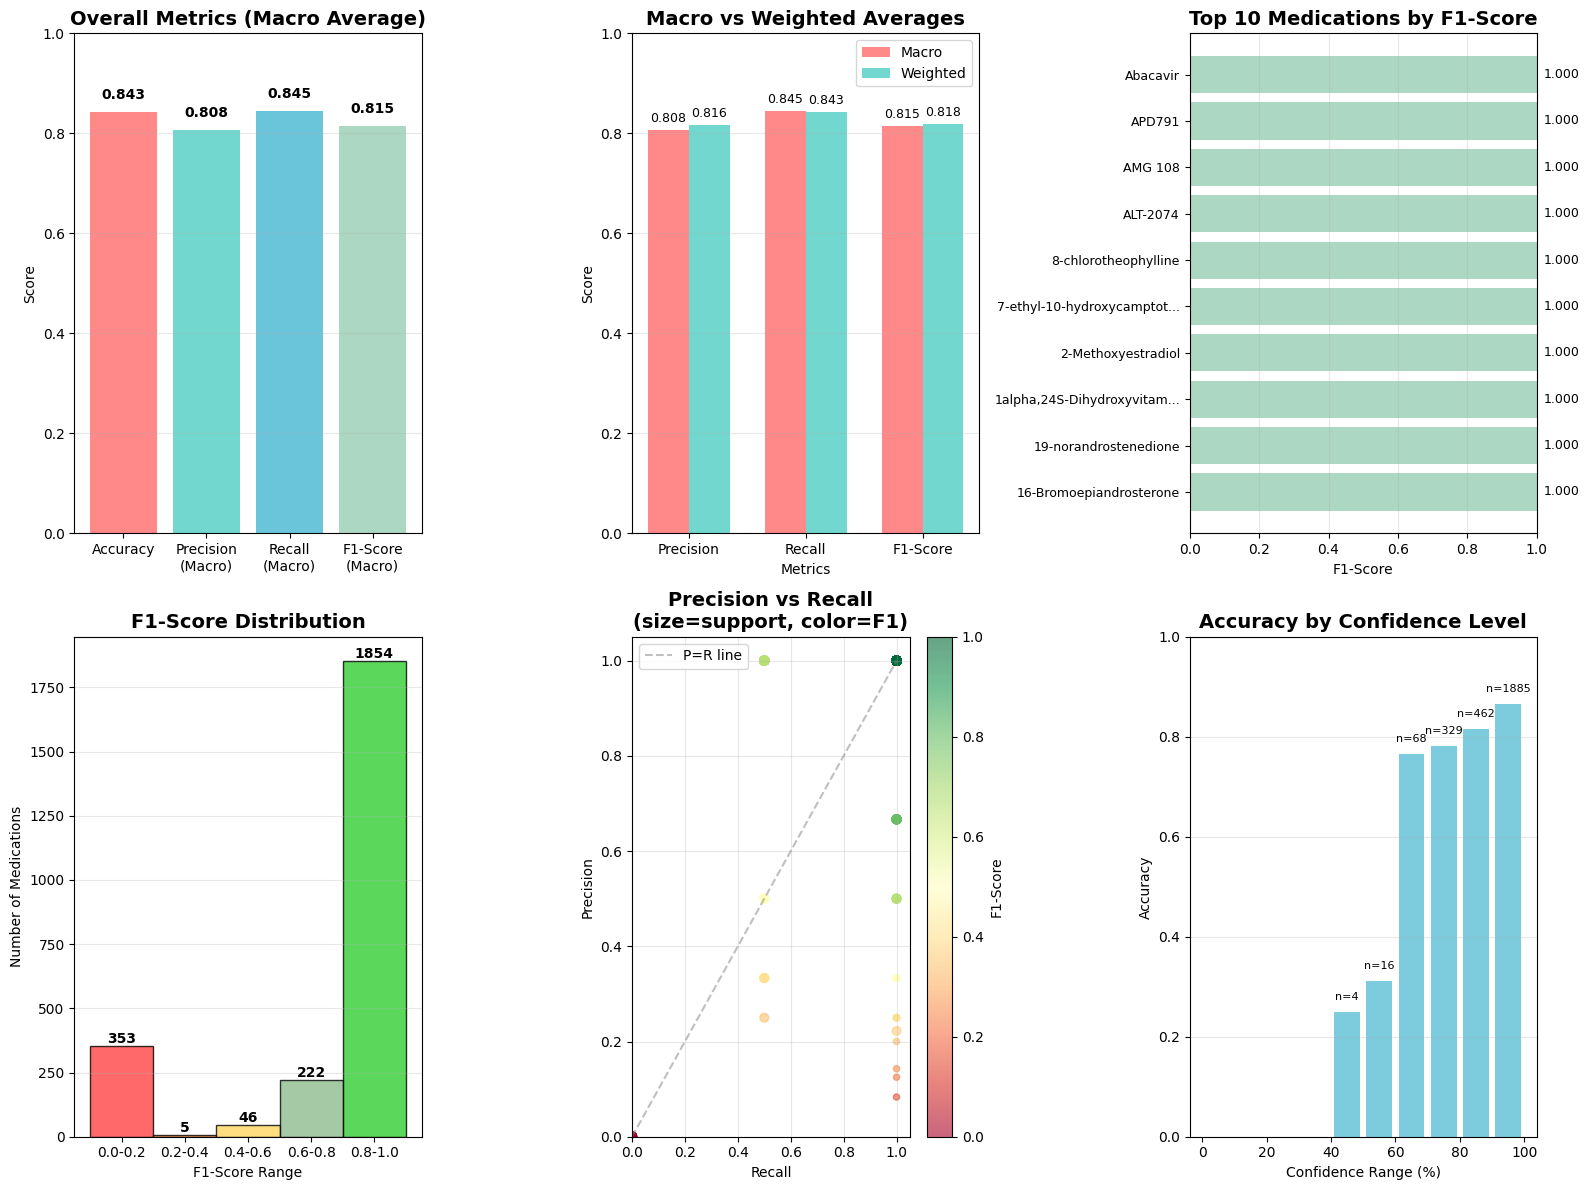


METRICS SUMMARY TABLE
Metric               Macro      Weighted  
--------------------------------------------------
Accuracy             0.8431     0.8431    
Precision            0.8075     0.8164    
Recall               0.8450     0.8431    
F1-Score             0.8152     0.8180    


In [ ]:
# Add these imports to your script if not already present
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

def calculate_precision_recall_f1(test_df, embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf):
    """
    Calculate precision, recall, F1 score, and accuracy with detailed analysis
    """
    print("\n" + "="*60)
    print("PRECISION, RECALL, F1 SCORE & ACCURACY EVALUATION")
    print("="*60)

    # Get true labels and predictions
    y_true = test_df['target_text'].tolist()
    X_test = test_df['input_text'].tolist()

    print("Generating predictions...")
    y_pred = []
    confidences = []

    for query in X_test:
        result = predict_medication(query, embedder, all_embeddings, all_conditions,
                                  all_medications, vectorizer, clf)
        y_pred.append(result['medication'])
        confidences.append(result['confidence'])

    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate macro averages (treat all classes equally)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Calculate weighted averages (weight by class frequency)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Calculate per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # Get unique class labels
    unique_labels = sorted(list(set(y_true + y_pred)))

    # Print overall results
    print("\n1. OVERALL METRICS:")
    print(f"   Accuracy:           {accuracy:.4f}")
    print(f"   Macro Precision:    {precision_macro:.4f}")
    print(f"   Macro Recall:       {recall_macro:.4f}")
    print(f"   Macro F1-Score:     {f1_macro:.4f}")
    print(f"   Weighted Precision: {precision_weighted:.4f}")
    print(f"   Weighted Recall:    {recall_weighted:.4f}")
    print(f"   Weighted F1-Score:  {f1_weighted:.4f}")

    # Create detailed per-class analysis
    print("\n2. PER-CLASS METRICS (Top 10 by support):")

    # Create DataFrame for easier handling
    per_class_df = pd.DataFrame({
        'medication': unique_labels,
        'precision': precision_per_class,
        'recall': recall_per_class,
        'f1_score': f1_per_class,
        'support': support_per_class
    })

    # Sort by support (number of test samples) and show top 10
    top_classes = per_class_df.nlargest(10, 'support')

    for idx, row in top_classes.iterrows():
        med_name = row['medication'][:40] + '...' if len(row['medication']) > 40 else row['medication']
        print(f"   {med_name}")
        print(f"   P: {row['precision']:.3f} | R: {row['recall']:.3f} | F1: {row['f1_score']:.3f} | Support: {int(row['support'])}")
        print()

    # Performance summary
    print("3. PERFORMANCE SUMMARY:")
    perfect_classes = (per_class_df['f1_score'] == 1.0).sum()
    good_classes = ((per_class_df['f1_score'] >= 0.8) & (per_class_df['f1_score'] < 1.0)).sum()
    poor_classes = (per_class_df['f1_score'] < 0.5).sum()

    print(f"   Perfect F1 (1.0):     {perfect_classes} medications")
    print(f"   Good F1 (≥0.8):       {good_classes} medications")
    print(f"   Poor F1 (<0.5):       {poor_classes} medications")
    print(f"   Total medications:    {len(per_class_df)} medications")

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'per_class_df': per_class_df,
        'y_true': y_true,
        'y_pred': y_pred,
        'confidences': confidences
    }

def visualize_metrics(metrics_data):
    """
    Create comprehensive visualizations for precision, recall, F1, and accuracy
    """
    print("\nGenerating visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))

    # 1. Overall Metrics Bar Chart
    ax1 = plt.subplot(2, 3, 1)
    overall_metrics = {
        'Accuracy': metrics_data['accuracy'],
        'Precision\n(Macro)': metrics_data['precision_macro'],
        'Recall\n(Macro)': metrics_data['recall_macro'],
        'F1-Score\n(Macro)': metrics_data['f1_macro']
    }

    bars = ax1.bar(overall_metrics.keys(), overall_metrics.values(),
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
    ax1.set_ylim(0, 1)
    ax1.set_title('Overall Metrics (Macro Average)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, overall_metrics.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Macro vs Weighted Comparison
    ax2 = plt.subplot(2, 3, 2)
    categories = ['Precision', 'Recall', 'F1-Score']
    macro_scores = [metrics_data['precision_macro'], metrics_data['recall_macro'], metrics_data['f1_macro']]
    weighted_scores = [metrics_data['precision_weighted'], metrics_data['recall_weighted'], metrics_data['f1_weighted']]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax2.bar(x - width/2, macro_scores, width, label='Macro', color='#FF6B6B', alpha=0.8)
    bars2 = ax2.bar(x + width/2, weighted_scores, width, label='Weighted', color='#4ECDC4', alpha=0.8)

    ax2.set_xlabel('Metrics')
    ax2.set_ylabel('Score')
    ax2.set_title('Macro vs Weighted Averages', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 3. Top 10 Medications by F1 Score
    ax3 = plt.subplot(2, 3, 3)
    top_performers = metrics_data['per_class_df'].nlargest(10, 'f1_score')

    # Truncate long medication names for better display
    med_names = [med[:25] + '...' if len(med) > 25 else med for med in top_performers['medication']]

    bars = ax3.barh(range(len(med_names)), top_performers['f1_score'],
                    color='#96CEB4', alpha=0.8)
    ax3.set_yticks(range(len(med_names)))
    ax3.set_yticklabels(med_names, fontsize=9)
    ax3.set_xlabel('F1-Score')
    ax3.set_title('Top 10 Medications by F1-Score', fontsize=14, fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, top_performers['f1_score'])):
        ax3.text(value + 0.02, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontsize=9)

    # 4. Performance Distribution
    ax4 = plt.subplot(2, 3, 4)
    f1_scores = metrics_data['per_class_df']['f1_score']

    # Create bins for F1 score ranges
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['0.0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
    colors = ['#FF4444', '#FF8C42', '#FFD662', '#8FBC8F', '#32CD32']

    # Create histogram and get the patches to color individually
    counts, bin_edges, patches = ax4.hist(f1_scores, bins=bins, alpha=0.8, edgecolor='black')

    # Color each bar individually
    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)

    ax4.set_xlabel('F1-Score Range')
    ax4.set_ylabel('Number of Medications')
    ax4.set_title('F1-Score Distribution', fontsize=14, fontweight='bold')
    ax4.set_xticks([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
    ax4.set_xticklabels(bin_labels)
    ax4.grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(counts):
        if count > 0:
            ax4.text((bins[i] + bins[i+1])/2, count + 0.5, str(int(count)),
                    ha='center', va='bottom', fontweight='bold')

    # 5. Precision vs Recall Scatter Plot
    ax5 = plt.subplot(2, 3, 5)
    per_class_df = metrics_data['per_class_df']

    # Size points by support (number of test samples)
    sizes = per_class_df['support'] * 20  # Scale up for visibility
    scatter = ax5.scatter(per_class_df['recall'], per_class_df['precision'],
                         s=sizes, alpha=0.6, c=per_class_df['f1_score'],
                         cmap='RdYlGn', vmin=0, vmax=1)

    ax5.set_xlabel('Recall')
    ax5.set_ylabel('Precision')
    ax5.set_title('Precision vs Recall\n(size=support, color=F1)', fontsize=14, fontweight='bold')
    ax5.set_xlim(0, 1.05)
    ax5.set_ylim(0, 1.05)
    ax5.grid(True, alpha=0.3)

    # Add diagonal line for F1 = 0.5 reference
    ax5.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='P=R line')
    ax5.legend()

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax5)
    cbar.set_label('F1-Score')

    # 6. Confidence vs Accuracy Analysis
    ax6 = plt.subplot(2, 3, 6)
    y_true = metrics_data['y_true']
    y_pred = metrics_data['y_pred']
    confidences = metrics_data['confidences']

    # Create bins for confidence analysis
    conf_bins = np.arange(0, 101, 10)
    bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
    bin_accuracies = []
    bin_counts = []

    for i in range(len(conf_bins) - 1):
        mask = (np.array(confidences) >= conf_bins[i]) & (np.array(confidences) < conf_bins[i+1])
        if mask.sum() > 0:
            bin_true = [y_true[j] for j in range(len(y_true)) if mask[j]]
            bin_pred = [y_pred[j] for j in range(len(y_pred)) if mask[j]]
            bin_acc = accuracy_score(bin_true, bin_pred)
            bin_accuracies.append(bin_acc)
            bin_counts.append(mask.sum())
        else:
            bin_accuracies.append(0)
            bin_counts.append(0)

    # Plot confidence vs accuracy
    bars = ax6.bar(bin_centers, bin_accuracies, width=8, alpha=0.7, color='#45B7D1')
    ax6.set_xlabel('Confidence Range (%)')
    ax6.set_ylabel('Accuracy')
    ax6.set_title('Accuracy by Confidence Level', fontsize=14, fontweight='bold')
    ax6.set_ylim(0, 1)
    ax6.grid(axis='y', alpha=0.3)

    # Add sample count labels
    for i, (bar, count, acc) in enumerate(zip(bars, bin_counts, bin_accuracies)):
        if count > 0:
            ax6.text(bar.get_x() + bar.get_width()/2, acc + 0.02,
                    f'n={count}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Create a summary table
    print("\n" + "="*50)
    print("METRICS SUMMARY TABLE")
    print("="*50)
    print(f"{'Metric':<20} {'Macro':<10} {'Weighted':<10}")
    print("-" * 50)
    print(f"{'Accuracy':<20} {metrics_data['accuracy']:<10.4f} {metrics_data['accuracy']:<10.4f}")
    print(f"{'Precision':<20} {metrics_data['precision_macro']:<10.4f} {metrics_data['precision_weighted']:<10.4f}")
    print(f"{'Recall':<20} {metrics_data['recall_macro']:<10.4f} {metrics_data['recall_weighted']:<10.4f}")
    print(f"{'F1-Score':<20} {metrics_data['f1_macro']:<10.4f} {metrics_data['f1_weighted']:<10.4f}")
    print("="*50)

def run_complete_evaluation(test_df, embedder, all_embeddings, all_conditions, all_medications, vectorizer, clf):
    """
    Run the complete evaluation with metrics calculation and visualization
    """
    # Calculate metrics
    metrics_data = calculate_precision_recall_f1(test_df, embedder, all_embeddings,
                                                 all_conditions, all_medications, vectorizer, clf)

    # Create visualizations
    visualize_metrics(metrics_data)

    return metrics_data

# To use this in your script, replace your evaluation section with:
print("Running complete evaluation with precision, recall, F1, and accuracy...")
evaluation_results = run_complete_evaluation(test_df, embedder, all_embeddings,
                                           all_conditions, all_medications, vectorizer, clf)